### Predict customers likely to respond to a marketing campaign
### This notebook uses the *campaign.xlsx* dataset. 
#### This notebook includes `'Data Preperation'`, `'Modeling'` and `'Evaluation'`for other models. `'Business Understanding'`, `'Data Understanding'` and `'Feature Exploration'` parts place in the different notebook. 

### Dataset description

- **AcceptedCmp1** - 1 if customer accepted the offer in the 1st campaign, 0 otherwise 
- **AcceptedCmp2** - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise 
- **AcceptedCmp3** - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise 
- **AcceptedCmp4** - 1 if customer accepted the offer in the 4th campaign, 0 otherwise 
- **AcceptedCmp5** - 1 if customer accepted the offer in the 5th campaign, 0 otherwise 
- **Response (target)** - 1 if customer accepted the offer in the last campaign, 0 otherwise 
- **Complain** - 1 if customer complained in the last 2 years
- **DtCustomer** - date of customer’s enrolment with the company
- **Education** - customer’s level of education
- **Marital** - customer’s marital status
- **Kidhome** - number of small children in customer’s household
- **Teenhome** - number of teenagers in customer’s household
- **Income** - customer’s yearly household income
- **MntFishProducts** - amount spent on fish products in the last 2 years
- **MntMeatProducts** - amount spent on meat products in the last 2 years
- **MntFruits** - amount spent on fruits products in the last 2 years
- **MntSweetProducts** - amount spent on sweet products in the last 2 years
- **MntWines** - amount spent on wine products in the last 2 years
- **MntGoldProds** - amount spent on gold products in the last 2 years
- **NumDealsPurchases** - number of purchases made with discount
- **NumCatalogPurchases** - number of purchases made using catalogue
- **NumStorePurchases** - number of purchases made directly in stores
- **NumWebPurchases** - number of purchases made through company’s web site
- **NumWebVisitsMonth** - number of visits to company’s web site in the last month
- **Recency** - number of days since the last purchase

##### **Overview**
<p>It is asked to develop a prediction model in such a way that it will be possible for the Marketing Department of a retail company to predict which customers are likely to respond to a marketing campaing based on information from a previous campaign.</p>
<p>A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses.</p>

##### **What is needed for the model to be considered successfull ?** 
Product manager Sarah striving to optimize the company marketing campaigns. With a keen eye on metrics like recall and F1 score, Sarah ensures their campaigns reach a broad audience (recall) while maintaining precision in targeting (F1 score > 0.5). 

##### **Model building**

To achieve the objective, it is followed a systematic approach, CRISP-DM, that involves several stages and proceed to train and evaluate predictive models using 4 different machine learning models with their best parameters such as:

- Decision Tree 
- Random Forest 
- XGBoost
- Logistic Regression

It is tried to explore various models from different families, including bagging techniques like Random Forest, boosting methods such as XGBoost, as well as Logistic Regression which is linear model. Logistic Regression is selected as a best model. 

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import re
import collections
from datetime import datetime

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Data Preprocessing
import imblearn
from imblearn.over_sampling import BorderlineSMOTE
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Machine Learning Models
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Model Selection and Evaluation
from sklearn.model_selection import GridSearchCV, train_test_split
from yellowbrick.model_selection import CVScores, LearningCurve
from yellowbrick.classifier import DiscriminationThreshold, ClassPredictionError, PrecisionRecallCurve, ROCAUC
from sklearn import metrics 

# Save the model
import pickle

# Assign random state for reproducebility
random_state=2024

# Set seaborn style
sns.set_style("whitegrid")

# Set the max_columns option to None to display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Print library versions
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("scikit-learn version:", sklearn.__version__) 

pandas version: 2.1.4
numpy version: 1.23.5
matplotlib version: 3.8.0
seaborn version: 0.13.2
scikit-learn version: 1.3.2


##### **Helper functions**

In [3]:
# WHY? Visualizing the confusion matrix is a critical step in model evaluation as it provides a detailed, understandable, and actionable insight into the strengths and weaknesses of your model's predictions

# Confusion matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel('')
    
    if title:
        plt.title(title)

In [4]:
# Plus, added specifity and geometric mean as evaluation metrics
# WHY? This code provides a robust framework for evaluating machine learning models by incorporating a variety of performance metrics. This leads to more informed and reliable assessments, ultimately improving model performance and applicability in real-world scenarios

# Specificity 
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Geometric mean
def g_mean(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return np.sqrt(sensitivity * specificity)

# Performance metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures = {
        'Accuracy': metricsObj.accuracy_score,
        'Precision': metricsObj.precision_score,
        'Recall': metricsObj.recall_score,
        'F1-score': metricsObj.f1_score,
        'Specificity': specificity_score,
        'G-Mean': g_mean
    }

    train_results = [measure_func(yTrain, yPredTrain) if measure_func not in [g_mean, specificity_score] else measure_func(yTrain, yPredTrain) for measure_func in measures.values()]
    test_results = [measure_func(yTest, yPredTest) if measure_func not in [g_mean, specificity_score] else measure_func(yTest, yPredTest) for measure_func in measures.values()]

    resultsDF = pd.DataFrame({'Measure': measures.keys(), 'Train': train_results, 'Test': test_results})
    return resultsDF

In [5]:
# WHY? Visualizing feature importances is a vital step in model evaluation and interpretation, providing insights that can guide model improvements, feature engineering, and decision-making processes

# Def function to visualize feature importances
def plot_feature_importances(model, feature_names):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(6,4))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), feature_names[indices], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()

##### **Load the data**

In [6]:
# Load the excel file
ds = pd.read_excel('campaign.xlsx', engine='openpyxl')

##### **Dataset first look**

In [7]:
# Show top 5 rows
print(ds.shape)
print(ds.columns)
print(ds.dtypes)
ds.head()

(2240, 29)
Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines               float64
MntFruits              float64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds           float64
NumD

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635.0,88.0,546,172,88,88.0,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11.0,1.0,6,2,1,6.0,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426.0,49.0,127,111,21,42.0,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11.0,4.0,20,10,3,5.0,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173.0,43.0,118,46,27,15.0,5,5,3,6,5,0,0,0,0,0,0,3,11,0


##### **Reformat the `Dt_Customer` dtype to datetime**

In [8]:
# Reformat
ds['Dt_Customer'] = pd.to_datetime(ds['Dt_Customer'])

# Confirm
print(ds['Dt_Customer'].dtype)

datetime64[ns]


### **3. DATA PREPARATION**

In [9]:
# Create a modeling dataset from the original dataset to prevent data leakage. Apply data cleaning and preprocessing on the copied version
# Since the dataset is small and memory usage is not a concern, deep copy is applied
X = ds.copy(deep=True)
print(X.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [10]:
# Drop the columns that don't provide meaningfull pattern for prediction
X.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

# Confirm
X.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')

##### **Data errors handling**

- If you remember from the EDA notebook, we had some data errors in `Dt_Customer` ('2042-11-09', '2041-02-25') and `MntSweetProducts` (2342344, 23423444, 234444) columns. These values were not logical based on the data at hand. For `MntSweetProducts` column, errors will replaced with NaN. Afterwards, they will imputed with median value of the column. Since the data is not normally distributed, median is used as a strategy. Errors in `Dt_Customer` will be dropped. 

##### **Handling `MntSweetProducts` errors** 

In [11]:
# Check the number of rows before handling data errors
print("Number of rows before data prepatation:",X.shape)

# Filter and select rows containing the error values in the 'MntSweetProducts' column to see clearly
rows_containing_errors = X[X['MntSweetProducts'].isin([2342344, 23423444, 234444])]
rows_containing_errors

Number of rows before data prepatation: (2240, 26)


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
523,1953,Graduation,Married,70503.0,0,0,2012-09-30,73,1379.0,33.0,216,0,2342344,66.0,1,2,4,9,6,0,1,1,0,0,0,0
563,1970,2n Cycle,Married,62466.0,0,1,2014-01-15,13,129.0,129.0,259,168,234444,83.0,5,6,3,12,4,0,0,0,0,0,0,0
634,1973,Graduation,Single,83917.0,0,0,2013-04-18,12,514.0,22.0,732,42,23423444,79.0,1,6,7,7,3,0,0,0,0,0,0,1


Number of data errors in `MntSweetProducts` is 3. So after replacing with NaN, the count of missing values should be 3 as well. 

In [12]:
error_values = [2342344, 23423444, 234444]
X.MntSweetProducts.replace(error_values, np.nan, inplace=True)

# Confirmation, check the missing values after replacing with NaN
print("Number of missing values after replacing errors with nan:", X.MntSweetProducts.isnull().sum())

Number of missing values after replacing errors with nan: 3


Perfect! We replaced the error values with NaN, now we will impute those 3 values with median value of the `MntSweetProducts`. 

In [13]:
# Print the median and max value for MntSweetProducts before imputation
print("Median value of MntSweetProducts column before imputation", X.MntSweetProducts.median())
print("Max value of MntSweetProducts column before imputation", X.MntSweetProducts.max())

Median value of MntSweetProducts column before imputation 8.0
Max value of MntSweetProducts column before imputation 263.0


Before the imputation median value of the column is 8 and the max value is 263. After the imputation, median and max values have to be same as well.

In [14]:
# Impute NaN values with median(8) value of the column
# KNN Imputer is tried but it was assigned same values all the time even if n_neighbors were changed. The column values was not proper for KNN Imputation. For this reason, we go with median imputation since the data is not normally distributed. 
imputer = SimpleImputer(strategy='median')
X['MntSweetProducts'] = imputer.fit_transform(X[['MntSweetProducts']])

In [15]:
# Check the median and the max value after imputation
print("Median value of MntSweetProducts after imputation:", X['MntSweetProducts'].median())
print("Max value of MntSweetProducts after imputation:", X['MntSweetProducts'].max())

# Check if the imputated rows has the 8 as a median value
X['MntSweetProducts'].iloc[[523, 563, 634]]

Median value of MntSweetProducts after imputation: 8.0
Max value of MntSweetProducts after imputation: 263.0


523    8.0
563    8.0
634    8.0
Name: MntSweetProducts, dtype: float64

Amazing! We are correctly imputed NaN values to median value 8. Corresponding rows has the median value in the `MntSweetProducts` column. We can move to handle `Dt_Customer` errors.

##### **Handling `Dt_Customer` errors**

In [16]:
# Filter and find rows with the error in the 'Dt_Customer' column
rows_to_remove = X[(X['Dt_Customer'] == pd.to_datetime('2042-11-09')) | (X['Dt_Customer'] == pd.to_datetime('2041-02-25'))]
rows_to_remove

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
46,1996,2n Cycle,Married,7500.0,0,0,2042-11-09,24,3.0,18.0,14,15,22.0,50.0,3,3,1,3,9,0,0,0,0,0,0,1
84,1987,Graduation,Divorced,81361.0,0,0,2041-02-25,18,163.0,23.0,424,27,65.0,76.0,1,3,10,13,1,0,0,0,0,0,0,0


As we can see, there are 2 errors in `Dt_Customer`. Maybe those errors were only a typo, for instance, instead of writing 2012 (--> 2042) or 2011 (--> 2041), it's written current dates. Since it is not sure and number of errors less for a concern, they will be dropped.

In [17]:
# Check max date before dropping 
print("Max date before dropping:", X['Dt_Customer'].max())

# Drop the rows containing error values 
X.drop(rows_to_remove.index, inplace=True)

# Check max date after dropping 
print("Max date after dropping:", X['Dt_Customer'].max())

# Check the number of rows after dropping
print("Number of rows after dropping:", X.shape)

Max date before dropping: 2042-11-09 00:00:00
Max date after dropping: 2014-06-29 00:00:00
Number of rows after dropping: (2238, 26)


2 rows are successfully dropped. It is always good to make sure everything is fine with the data step by step.

##### **Remove outliers**

In [18]:
# Define continuous columns 
continuous_cols =  ['Income',
                    'Recency',
                    'MntWines', 
                    'MntFruits', 
                    'MntMeatProducts', 
                    'MntFishProducts', 
                    'MntSweetProducts',
                    'MntGoldProds', 
                    'NumDealsPurchases', 
                    'NumWebPurchases', 
                    'NumCatalogPurchases', 
                    'NumStorePurchases', 
                    'NumWebVisitsMonth']

# Loop for all the columns in continuous columns
for col in continuous_cols:
    Q1, Q3 = X[col].quantile([0.10, 0.90]) # Quantile range
    IQR = Q3 - Q1 # Calculate IQR
    lower_fence = Q1 - 1.5 * IQR # Define lower fence
    upper_fence = Q3 + 1.5 * IQR # Define upper fence

    # Store the values under lower fence and above upper fence as outliers
    outliers = X[(X[col] < lower_fence) | (X[col] > upper_fence)].index 

    # Drop outliers
    X.drop(outliers, inplace=True)

In [19]:
# Confirmation
X.shape

(2215, 26)

There were 23 data points as outliers between the range (0.10, 0.90), they are dropped. Without losing much information, it is tried to reduce the effect of outliers.

##### **Missing value imputation**


In [20]:
# Check summary statistics before imputation
X[['Income', 'MntGoldProds', 'MntFruits', 'MntWines']].describe()

,Income,MntGoldProds,MntFruits,MntWines
count,2194.000000,2163.000000,2213.000000,2212.000000
mean,51957.393801,44.275543,26.434704,305.386076
std,21001.469999,51.480054,39.861218,337.446458
min,3502.000000,0.000000,0.000000,0.000000
25%,35422.250000,9.000000,2.000000,24.000000
50%,51371.000000,25.000000,8.000000,176.000000
75%,68487.000000,57.000000,33.000000,505.000000
max,162397.000000,262.000000,199.000000,1493.000000


In [21]:
# Observe rows with missing values in the 'Income' column before imputation
missing_income_rows = X[X['Income'].isnull()]
missing_income_rows.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
10,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5.0,5.0,6,0,2.0,1.0,1,1,0,2,7,0,0,0,0,0,0,0
43,1959,PhD,Single,NaN,0,0,2013-11-05,80,81.0,11.0,50,3,2.0,39.0,1,1,3,4,2,0,0,0,0,0,0,0
48,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48.0,5.0,48,6,10.0,7.0,3,2,1,4,6,0,0,0,0,0,0,0
58,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11.0,3.0,22,2,2.0,6.0,2,2,0,3,6,0,0,0,0,0,0,0
71,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25.0,3.0,43,17,4.0,17.0,3,3,0,3,8,0,0,0,0,0,0,0


In [22]:
# Observe rows with missing values in the 'MntGoldProds' column before imputation
missing_gold_rows = X[X['MntGoldProds'].isnull()]
missing_gold_rows.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
613,1967,Graduation,Married,22574.0,2,1,2013-10-28,28,25.0,0.0,8,2,0.0,NaN,2,2,0,3,7,0,0,0,0,0,0,0
614,1969,PhD,Single,48240.0,0,0,2012-11-09,73,389.0,91.0,248,64,49.0,NaN,3,6,3,13,5,0,0,0,0,0,0,1
615,1974,Graduation,Married,45837.0,1,1,2013-07-26,88,215.0,13.0,87,17,17.0,NaN,5,6,2,5,7,0,0,0,0,0,0,0
616,1965,Master,Single,35791.0,2,1,2013-05-06,94,27.0,0.0,5,0,0.0,NaN,2,1,0,3,8,0,0,0,0,0,0,0
617,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85.0,1.0,16,2,1.0,NaN,0,0,0,1,1,0,0,0,0,0,0,0


In [23]:
# Observe rows with missing values in the 'MntFruits' column before imputation
missing_fruits_rows = X[X['MntFruits'].isnull()]
missing_fruits_rows

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
336,1968,Graduation,Divorced,75693.0,0,0,2012-12-06,10,797.0,NaN,293,72,97.0,30.0,1,11,4,6,4,0,1,1,1,0,0,1
373,1966,Graduation,Single,63810.0,0,1,2012-11-11,45,977.0,NaN,253,16,12.0,101.0,4,4,3,12,8,0,1,0,0,0,0,0


In [24]:
# Observe rows with missing values in the 'MntWines' column before imputation
missing_wines_rows = X[X['MntWines'].isnull()]
missing_wines_rows

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
150,1953,Master,Married,59354.0,0,2,2014-04-24,59,NaN,21.0,78,39,13.0,13.0,1,4,4,7,3,0,0,0,0,0,0,0
190,1978,Basic,Together,24882.0,1,0,2012-09-09,52,NaN,4.0,10,29,0.0,36.0,1,1,1,2,6,1,0,0,0,0,0,0
368,1962,Graduation,Together,72025.0,0,0,2012-11-17,27,NaN,33.0,549,151,133.0,233.0,1,4,3,8,3,0,0,0,0,0,0,0


##### **KNN Imputation**

In [25]:
# Define the columns to impute
columns_to_impute = ['Income', 'MntGoldProds', 'MntFruits', 'MntWines']  

# Initialize the KNN imputer with 3 number of neighbors
knn_imputer = KNNImputer(n_neighbors=3)  

# Impute missing values for the selected columns
X[columns_to_impute] = knn_imputer.fit_transform(X[columns_to_impute])

In [26]:
# Check summary statistics after imputation
X[['Income', 'MntGoldProds', 'MntFruits', 'MntWines']].describe()

,Income,MntGoldProds,MntFruits,MntWines
count,2215.000000,2215.000000,2215.000000,2215.000000
mean,51910.670730,43.815500,26.484725,305.429195
std,20962.376601,51.144525,39.884569,337.294162
min,3502.000000,0.000000,0.000000,0.000000
25%,35482.000000,9.000000,2.000000,24.000000
50%,51287.000000,24.000000,8.000000,176.000000
75%,68429.500000,56.000000,33.000000,505.000000
max,162397.000000,262.000000,199.000000,1493.000000


In [27]:
# Check if the imputation values make sense for Income
X.iloc[[9, 40, 44, 54, 67]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
10,1983,Graduation,Married,37287.333333,1,0,2013-11-15,11,5.0,5.0,6,0,2.0,1.0,1,1,0,2,7,0,0,0,0,0,0,0
43,1959,PhD,Single,37464.000000,0,0,2013-11-05,80,81.0,11.0,50,3,2.0,39.0,1,1,3,4,2,0,0,0,0,0,0,0
48,1951,Graduation,Single,41730.000000,2,1,2014-01-01,96,48.0,5.0,48,6,10.0,7.0,3,2,1,4,6,0,0,0,0,0,0,0
58,1982,Graduation,Single,22945.666667,1,0,2013-06-17,57,11.0,3.0,22,2,2.0,6.0,2,2,0,3,6,0,0,0,0,0,0,0
71,1973,2n Cycle,Married,41353.333333,1,0,2012-09-14,25,25.0,3.0,43,17,4.0,17.0,3,3,0,3,8,0,0,0,0,0,0,0


In [28]:
# Check if the imputation values make sense for MntGoldProds
X.iloc[[604, 605, 606, 607, 608]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
613,1967,Graduation,Married,22574.0,2,1,2013-10-28,28,25.0,0.0,8,2,0.0,4.000000,2,2,0,3,7,0,0,0,0,0,0,0
614,1969,PhD,Single,48240.0,0,0,2012-11-09,73,389.0,91.0,248,64,49.0,43.000000,3,6,3,13,5,0,0,0,0,0,0,1
615,1974,Graduation,Married,45837.0,1,1,2013-07-26,88,215.0,13.0,87,17,17.0,95.000000,5,6,2,5,7,0,0,0,0,0,0,0
616,1965,Master,Single,35791.0,2,1,2013-05-06,94,27.0,0.0,5,0,0.0,7.666667,2,1,0,3,8,0,0,0,0,0,0,0
617,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85.0,1.0,16,2,1.0,18.333333,0,0,0,1,1,0,0,0,0,0,0,0


In [29]:
# Check if the imputation values make sense for MntWines
X.iloc[[145, 184, 362]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
151,1969,Graduation,Married,65747.0,0,1,2014-03-07,96,346.0,17.0,48,23,13.0,13.0,4,8,1,6,6,0,1,0,0,0,0,0
191,1989,PhD,Together,66973.0,0,0,2013-05-17,98,466.0,22.0,432,147,113.0,102.0,1,8,7,12,3,0,0,0,0,0,0,0
370,1984,2n Cycle,Married,35684.0,1,0,2014-04-22,66,10.0,4.0,7,0,6.0,3.0,1,1,0,3,6,0,0,0,0,0,0,0


In [30]:
# Check if the imputation values make sense for MntFruits
X.iloc[[330, 367]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
338,1965,Graduation,Together,83003.0,0,0,2013-03-03,18,856.0,61.0,570,40,25.0,122.0,1,7,6,8,3,0,0,1,0,0,0,1
375,1975,Master,Single,46098.0,1,1,2012-08-18,86,57.0,0.0,27,0,0.0,36.0,4,3,2,2,8,0,0,0,0,0,0,0


Summary statistics (compare before and after) indicates that the missing values were filled in a manner that maintains the central tendency of the dataset, as reflected in the mean values. This preservation of mean values indicates that the imputation process did not introduce significant bias or distortion into the dataset. Corresponding rows are printed to check values carefully. The values differ meaningfully. We imputed missing values successfully. We are good to go! 

##### **Create binary column for `higher_education`**

In [31]:
# Create a higher education columns
higher_education = ['Graduation', 'Master', 'PhD']
#lower_education = ['Basic', '2n Cycle']

# Create new feature column
X['higher_education'] = X['Education'].apply(lambda x: 1 if x in higher_education else 0)
#X['lower_education'] = X['Education'].apply(lambda x: 1 if x in lower_education else 0)

In [32]:
# Confirm
print(X[['Education', 'higher_education']].head(20))

# Drop the Education column
X.drop(['Education'], axis=1, inplace=True)

     Education  higher_education
0   Graduation                 1
1   Graduation                 1
2   Graduation                 1
3   Graduation                 1
4          PhD                 1
5       Master                 1
6   Graduation                 1
7          PhD                 1
8          PhD                 1
10  Graduation                 1
11       Basic                 0
12  Graduation                 1
13      Master                 1
14  Graduation                 1
15         PhD                 1
16  Graduation                 1
17  Graduation                 1
18      Master                 1
19    2n Cycle                 0
20  Graduation                 1


Instead of creating two encoded columns like higher_education and lower_education, only higher_education column, which gives the same information, is created to reduce the noise . 

##### **Remapping the `marital_status` categories**

In [33]:
# 'Married' or 'Together' are kept as is, while all other marital statuses are labeled as 'Single'
X['marital_status'] = X['Marital_Status'].apply(lambda x: x if x in ['Married', 'Together'] else 'Single')

# Drop Marital_Status
X.drop(['Marital_Status'], axis=1, inplace=True)

# Confirm
X.marital_status.value_counts()

marital_status
Married     855
Single      790
Together    570
Name: count, dtype: int64

##### **Create `age` column from `Year_Birth` and bin**

In [34]:
# Calculate the current year
current_year = datetime.now().year

# Calculate the age of each individual
X['age'] = current_year - X['Year_Birth']

# Display the first few rows to verify the new 'age' column
print(X[['Year_Birth', 'age']].head())

# Drop the Year_Birth column
X.drop(['Year_Birth'], axis=1, inplace=True)

   Year_Birth  age
0        1957   67
1        1954   70
2        1965   59
3        1984   40
4        1981   43


In [35]:
# Check percentiles for binning
X.age.describe()

count    2215.000000
mean       55.215350
std        11.970912
min        28.000000
25%        47.000000
50%        54.000000
75%        65.000000
max       131.000000
Name: age, dtype: float64

In [36]:
# Define label and bins based on the percentiles
age_bins = [0, 47, 54, 132]
age_labels = ['Young', 'Middle-aged', 'Senior']
age_category = pd.cut(X['age'], bins=age_bins, labels=age_labels)
X['age_category'] = age_category

In [37]:
# Confirm 
print(X[['age', 'age_category']].head(10))

# Drop the age column
X.drop(['age'], axis=1, inplace=True)

    age age_category
0    67       Senior
1    70       Senior
2    59       Senior
3    40        Young
4    43        Young
5    57       Senior
6    53  Middle-aged
7    39        Young
8    50  Middle-aged
10   41        Young


##### **Create `length_of_membership` column from `Dt_Customer`**

In [38]:
# Convert 'Dt_Customer' to datetime format
X['Dt_Customer'] = pd.to_datetime(X['Dt_Customer'])

# Calculate the length of membership (in years)
X['length_of_membership'] = current_year - X['Dt_Customer'].dt.year

# Display the first few rows to verify the new 'length_of_membership' column
print(X[['Dt_Customer', 'length_of_membership']].head())

# Drop the Dt_Customer column
X.drop(['Dt_Customer'], axis=1, inplace=True)

  Dt_Customer  length_of_membership
0  2012-09-04                    12
1  2014-03-08                    10
2  2013-08-21                    11
3  2014-02-10                    10
4  2014-01-19                    10


##### **Create `total_amount_spent` column by summing up `product columns`**

In [39]:
# List of columns representing amounts spent on different product categories
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Calculate the total amount spent by each individual
X['total_amount_spent'] = X[product_cols].sum(axis=1)

# Display the first 5 rows to verify the new 'total_amount_spent' column
print(X[product_cols + ['total_amount_spent']].head(1))

# Drop the columns representing amounts spent on different product categories
X.drop(product_cols, axis=1, inplace=True)

   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0     635.0       88.0              546              172              88.0   

   MntGoldProds  total_amount_spent  
0          88.0              1617.0  


The product numbers were successfully summed, and a new column was created to store the total sum.

##### **Create `total_num_purchases` column by summing up `purchases from channels`**

In [40]:
# List of columns representing number of purchases from different channels
purchase_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

# Calculate the total number of purchases made by each individual
X['total_num_purchases'] = X[purchase_cols].sum(axis=1)

# Display the first few row to verify the new 'total_num_purchases' column
print(X[purchase_cols + ['total_num_purchases']].head(1))

# Drop the purchase cols
X.drop(purchase_cols, axis=1, inplace=True)

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                  3                8                   10                  4   

   total_num_purchases  
0                   25  


##### **Create `total_campaigns_accepted` column by summing up `campaigns`**

In [41]:
# List of columns representing acceptance of marketing campaigns
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

# Calculate the total number of marketing campaigns accepted by each individual
X['total_campaigns_accepted'] = X[campaign_cols].sum(axis=1)

# Display the first few rows to verify the new 'total_campaigns_accepted' column
print(X['total_campaigns_accepted'].tail(10))

# Drop campaign cols
X.drop(campaign_cols, axis=1, inplace=True)

2229    0
2230    1
2231    0
2232    0
2234    0
2235    0
2236    1
2237    1
2238    0
2239    0
Name: total_campaigns_accepted, dtype: int64


##### **Create `family_size` column by summing up `Kidhome` and `Teenhome`**

In [42]:
# Calculate the family size by summing the 'Kidhome' and 'Teenhome' columns
X['family_size'] = X['Kidhome'] + X['Teenhome']

# Display the first few rows to verify the new 'family_size' column
print(X[['Kidhome', 'Teenhome', 'family_size']].head())

# Drop the columns
X.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

   Kidhome  Teenhome  family_size
0        0         0            0
1        1         1            2
2        0         0            0
3        1         0            1
4        1         0            1


##### **Bin and label the `Income` column**

In [43]:
# Check percentiles for binning
X.Income.describe()

count      2215.000000
mean      51910.670730
std       20962.376601
min        3502.000000
25%       35482.000000
50%       51287.000000
75%       68429.500000
max      162397.000000
Name: Income, dtype: float64

In [44]:
# Define the income level bins based on quartiles
income_bins = [0, 35482, 51287, 68429, 999999]  # Very Low, Low, Medium, High
income_labels = ['Very Low', 'Low', 'Medium', 'High']

# Create a new column 'income_level' based on the income bins
X['income_level'] = pd.cut(X['Income'], bins=income_bins, labels=income_labels)

# Display the first few rows to verify the new 'income_level' column
print(X[['Income', 'income_level']].head())

# Drop Income column
X.drop(['Income'], axis=1, inplace=True)

    Income income_level
0  58138.0       Medium
1  46344.0          Low
2  71613.0         High
3  26646.0     Very Low
4  58293.0       Medium


In [45]:
# Define the columns 
cols = ['age_category', 'marital_status', 'income_level']

# Initialize and fit the OneHotEncoder
# One-hot encoding is well-suited for decision tree models because it preserves categorical information, ensures interpretability, and avoids bias towards numerical features, making it an effective preprocessing technique for categorical data in decision tree-based algorithms
ce_onehotencoder = ce.OneHotEncoder(cols=cols)
X = ce_onehotencoder.fit_transform(X)

In [46]:
# Confirm
X.head()

,Recency,NumWebVisitsMonth,Complain,Response,higher_education,marital_status_1,marital_status_2,marital_status_3,age_category_1,age_category_2,age_category_3,length_of_membership,total_amount_spent,total_num_purchases,total_campaigns_accepted,family_size,income_level_1,income_level_2,income_level_3,income_level_4
0,58,7,0,1,1,1,0,0,0,0,1,12,1617.0,25,0,0,0,0,1,0
1,38,5,0,0,1,1,0,0,0,0,1,10,27.0,6,0,2,0,1,0,0
2,26,4,0,0,1,0,1,0,0,0,1,11,776.0,21,0,0,0,0,0,1
3,26,6,0,0,1,0,1,0,1,0,0,10,53.0,8,0,1,1,0,0,0
4,94,5,0,0,1,0,0,1,1,0,0,10,422.0,19,0,1,0,0,1,0


In [47]:
# Summary statistics for all variables after data preparation - Transpose
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Recency,2215.0,49.191422,28.918529,0.0,24.0,49.0,74.0,99.0
NumWebVisitsMonth,2215.0,5.295711,2.315974,0.0,3.0,6.0,7.0,17.0
Complain,2215.0,0.009481,0.096929,0.0,0.0,0.0,0.0,1.0
Response,2215.0,0.150339,0.357484,0.0,0.0,0.0,0.0,1.0
higher_education,2215.0,0.885779,0.318152,0.0,1.0,1.0,1.0,1.0
marital_status_1,2215.0,0.356659,0.479121,0.0,0.0,0.0,1.0,1.0
marital_status_2,2215.0,0.257336,0.437265,0.0,0.0,0.0,1.0,1.0
marital_status_3,2215.0,0.386005,0.486942,0.0,0.0,0.0,1.0,1.0
age_category_1,2215.0,0.269074,0.443579,0.0,0.0,0.0,1.0,1.0
age_category_2,2215.0,0.250113,0.433176,0.0,0.0,0.0,0.5,1.0


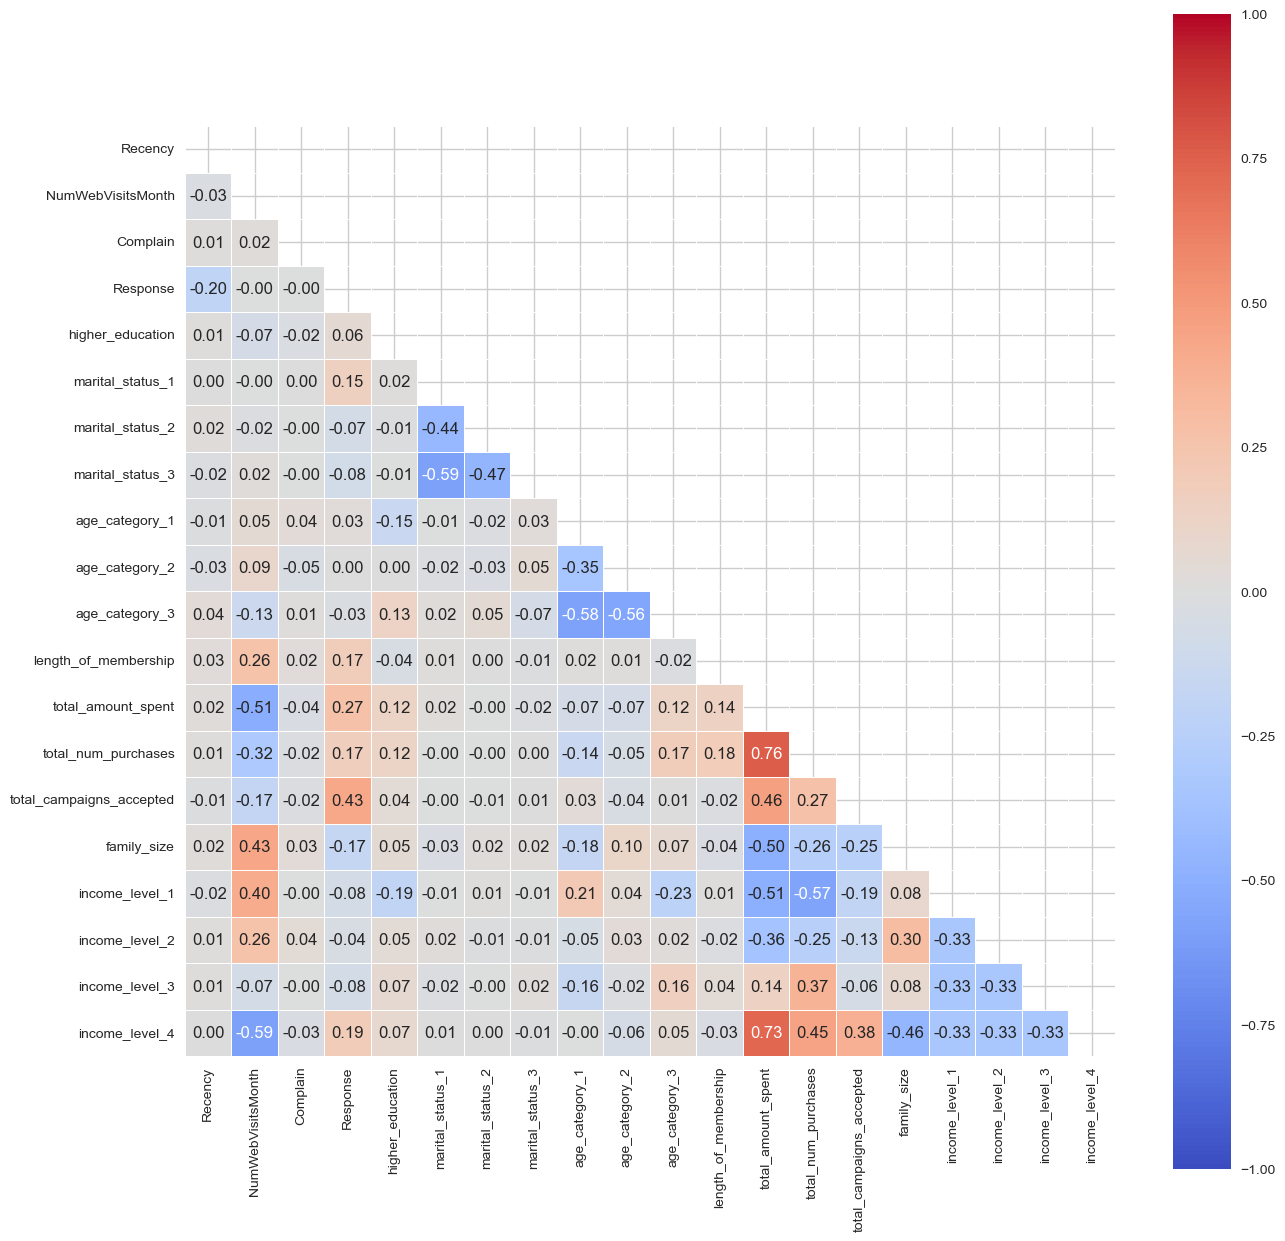

In [48]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the size of the figure
plt.figure(figsize=(15, 15))

# Plot the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask,
                square=True,
                linewidths=.5,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt=".2f")
plt.show()

There is no highly correlated variable. 

### **4. MODELING**

In [49]:
# Create the target variable
y = X['Response']

In [50]:
# Make sure target variable is correctly assigned
y.unique()

array([1, 0])

In [51]:
# Drop the target from the training data
X = X.drop(['Response'], axis=1)

In [52]:
# Split the data into train and test
# By using stratify=y, we ensure that the proportion of each class in the training and test sets reflects the proportion of classes in the original dataset. This helps prevent biases, especially when dealing with imbalanced datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y, random_state=random_state)

In [53]:
# Check shape of the splits to confirm
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1661, 19)
Shape of X_test: (554, 19)
Shape of y_train: (1661,)
Shape of y_test: (554,)


Counter({0: 1411, 1: 250})
Response
0    0.849488
1    0.150512
Name: proportion, dtype: float64
Imbalance ratio: 5.644


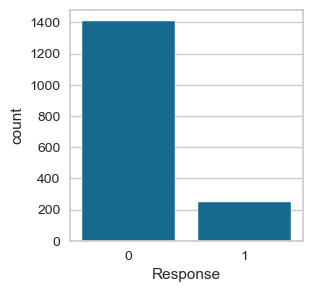

In [54]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

# Calculate the imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print("Imbalance ratio:", imbalance_ratio)

\begin{align}
ImbalanceRatio = NumberOfSamplesInClass0 / NumberOfSamplesInClass1
\end{align}

**Imbalance ratio** = 1411 / 250 ≈ **5.64**

This means that **class 0 is approximately 5.64 times larger than class 1**, indicating a significant class imbalance in the data at hand.

Different oversampling techniques will be applied and to reduce the bias. And the technique that gives the best generalization and F1 score among the training and test set will be selected.

Counter({1: 1411, 0: 1411})


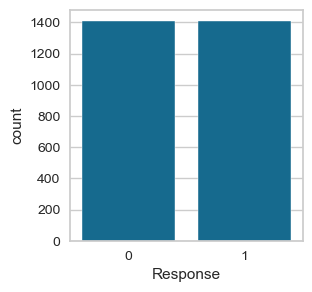

In [55]:
# It is applied SMOTE, BorderlineSMOTE, ADASYN, SMOTE-ENN, Geometric SMOTE, Random Oversampling methods. Borderline smote generalize better in train and test sets in tree-based models.

# Initialize Borderline SMOTE
borderline = BorderlineSMOTE(random_state=random_state)

# Apply Borderline SMOTE to generate new instances (oversampling)
X_train2, y_train2 = borderline.fit_resample(X_train, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))

# Visualize class distribution after applying Borderline SMOTE
fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response': y_train2}), ax=ax)
plt.show()

### Decision Tree

#### GridSearchCV - Hyperparameter Tuning 

In [56]:
# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier()

# Define parameter grid
param_grid = {
    'max_depth': [3],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='f1_weighted', cv=10)
grid_search.fit(X_train2, y_train2)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best F1 score found
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score: 0.7603321681405242


In [57]:
# Initialize Decision Tree Classifier with best parameters
dt = DecisionTreeClassifier(**grid_search.best_params_, random_state=random_state)

#### Learning Curve

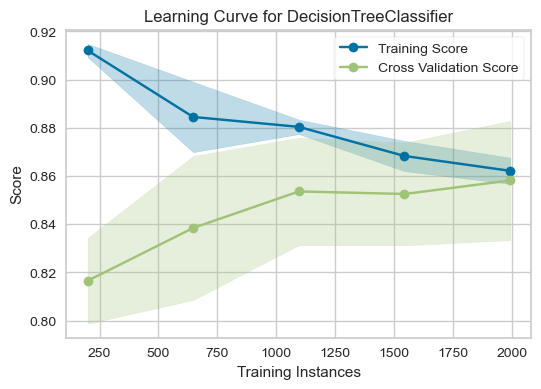

<Axes: title={'center': 'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [58]:
plt.figure(figsize=(6,4))
# Plot the learning curve
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=dt, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, random_state=random_state)
visualizer.fit(X, y)
visualizer.show()   

#### Cross Validation

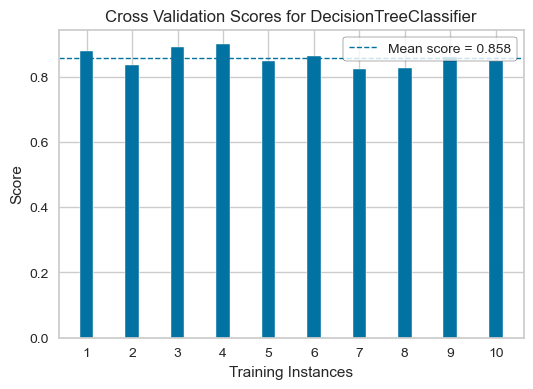

<Axes: title={'center': 'Cross Validation Scores for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [59]:
plt.figure(figsize=(6,4))
# Visualize cross validation scores
visualizer = CVScores(dt, cv=10, scoring='f1_weighted')

visualizer.fit(X, y)                      # Fit the data to the visualizer
visualizer.show()                         # Finalize and render the figure

#### Discrimination Threshold

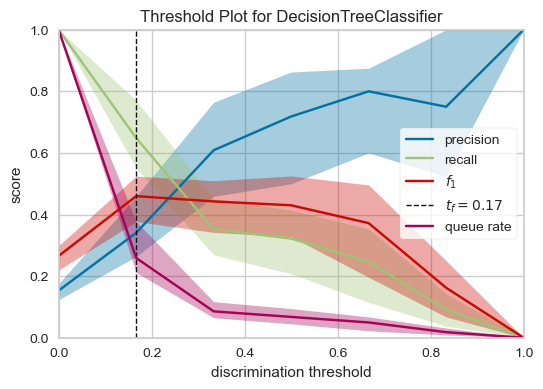

<Axes: title={'center': 'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [60]:
plt.figure(figsize=(6,4))
# Instantiate the DiscriminationThreshold visualizer with the model
visualizer = DiscriminationThreshold(dt, random_state=random_state)

# Fit the data to the visualizer
visualizer.fit(X, y)

# Visualize the discrimination threshold
visualizer.show()

In [61]:
# Train the model
dt.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=3, random_state=2024)

In [62]:
# Predict train and test sets
y_pred_train = dt.predict(X_train2)
y_pred_test = dt.predict(X_test)

In [63]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,Accuracy,0.775337,0.714801
1,Precision,0.761969,0.295082
2,Recall,0.800850,0.650602
3,F1-score,0.780926,0.406015
4,Specificity,0.749823,0.726115
5,G-Mean,0.774917,0.687322


#### Confusion Matrix

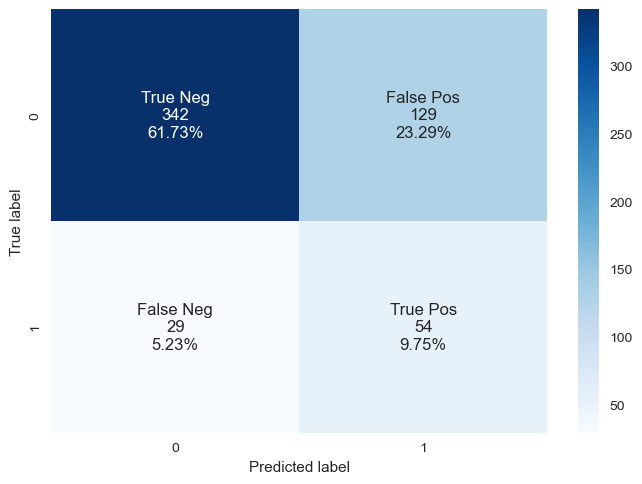

In [64]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

#### ROC-AUC

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


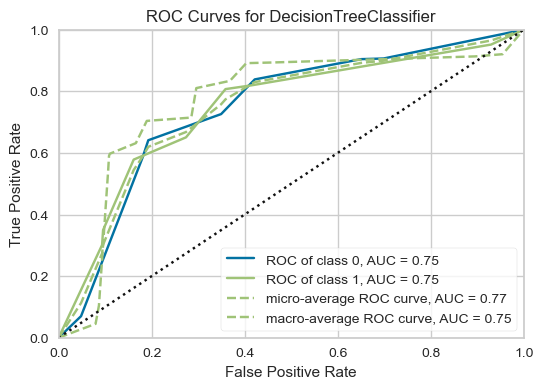

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [65]:
plt.figure(figsize=(6,4))
# ROC curve
visualizer = ROCAUC(dt, classes=['0','1'])
visualizer.fit(X_train2, y_train2)
visualizer.score(X_test, y_test)
visualizer.show()

#### Precision-Recall Curve

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


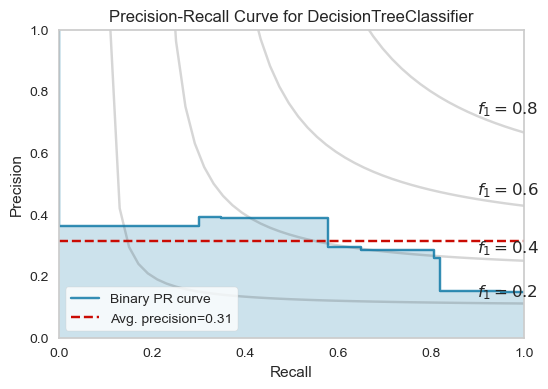

<Axes: title={'center': 'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [66]:
plt.figure(figsize=(6,4))
# Precison-Recall curve
viz = PrecisionRecallCurve(dt, ap_score=True, iso_f1_curves=True,)
viz.fit(X_train2, y_train2)
viz.score(X_test, y_test)

viz.show()

#### Class Prediction Error

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


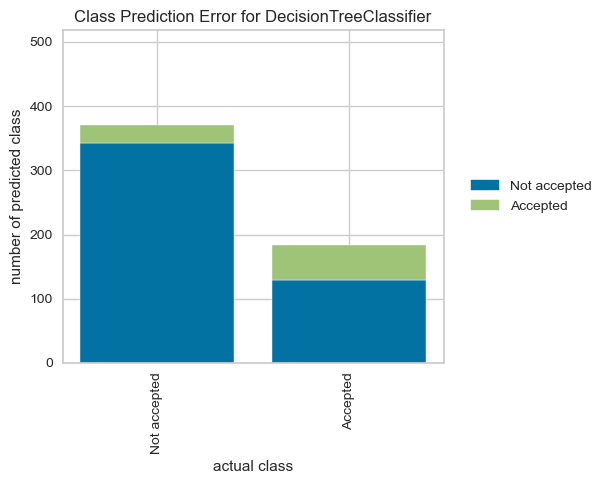

<Axes: title={'center': 'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [67]:
plt.figure(figsize=(7,5))
classes = ['Not accepted','Accepted']
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(dt, classes=classes)

# Fit the training data to the visualizer
visualizer.fit(X_train2, y_train2)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

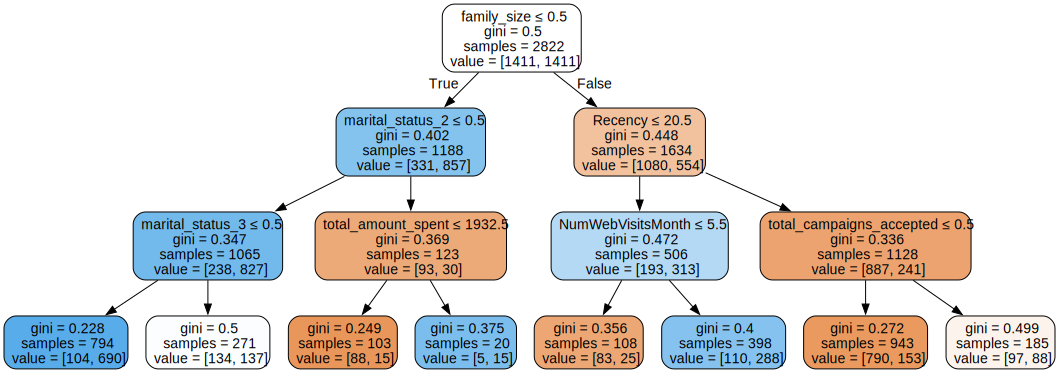

In [68]:
# Export the decision tree to Graphviz format
dot_data = tree.export_graphviz(dt, out_file=None,
                                feature_names=[re.sub('[^a-zA-Z0-9_]', '_', feature) for feature in X_train2.columns],
                                filled=True, rounded=True,
                                special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
# graph.render("decision_tree")  # Optionally save the tree to a file
# graph.view()  # View the tree in the default viewer
graph

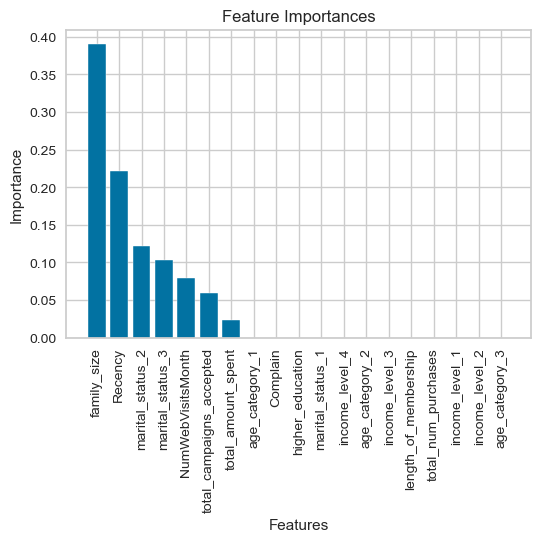

In [69]:
# Call the plot_feature_importances function
plot_feature_importances(dt, X_train2.columns)

### Random Forest

#### GridSearchCV - Hyperparameter Tuning 

In [70]:
# Define the Random Forest classifier
rf = RandomForestClassifier()

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [50],
    'max_depth': [3],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, scoring='f1_weighted')

# Perform Grid Search cross-validation
grid_search.fit(X_train2, y_train2)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best F1 score found
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 Score: 0.8423919851049405


In [71]:
# Initialize the RandomForest classifier with best parameters
rf = RandomForestClassifier(**grid_search.best_params_, random_state=random_state)

#### Learning Curve

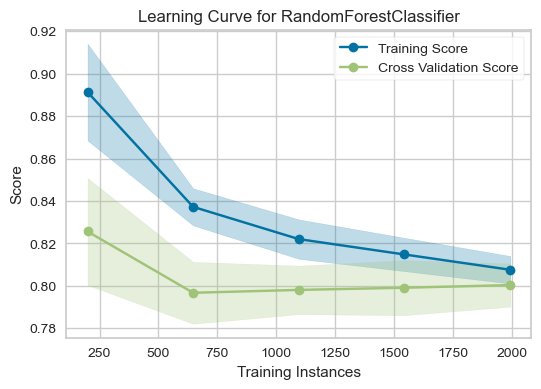

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [72]:
plt.figure(figsize=(6,4))
# Plot the learning curve
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=rf, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, random_state=random_state)
visualizer.fit(X, y)
visualizer.show()   

#### Cross Validation

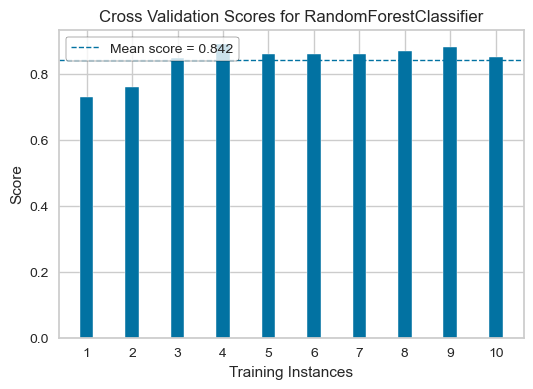

<Axes: title={'center': 'Cross Validation Scores for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [73]:
plt.figure(figsize=(6,4))
# Visualize cross validation scores
visualizer = CVScores(rf, cv=10, scoring='f1_weighted')

visualizer.fit(X_train2, y_train2)        # Fit the data to the visualizer
visualizer.show()                         # Finalize and render the figure

#### Discrimination Threshold

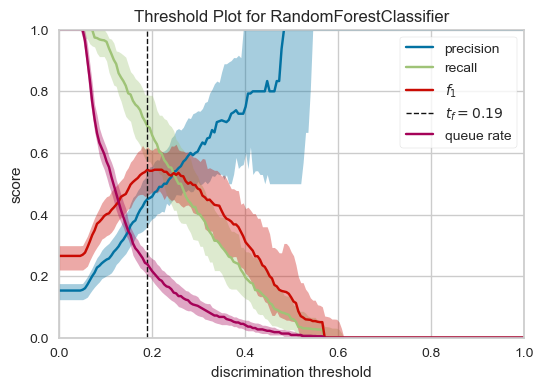

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [74]:
plt.figure(figsize=(6,4))
# Instantiate the DiscriminationThreshold visualizer with the model
visualizer = DiscriminationThreshold(rf, random_state=random_state)

# Fit the data to the visualizer
visualizer.fit(X, y)

# Visualize the discrimination threshold
visualizer.show()

In [75]:
# Train the model
rf.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=2024)

In [76]:
# Predict train and test sets
y_pred_train = rf.predict(X_train2) 
y_pred_test = rf.predict(X_test) 

In [77]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,Accuracy,0.853296,0.788809
1,Precision,0.846903,0.380282
2,Recall,0.862509,0.650602
3,F1-score,0.854635,0.480000
4,Specificity,0.844082,0.813163
5,G-Mean,0.853246,0.727356


#### ROC-AUC

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


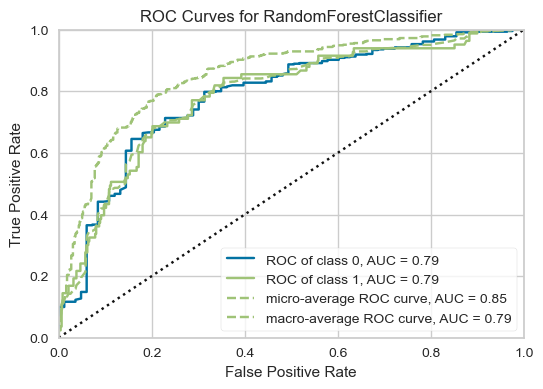

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [78]:
plt.figure(figsize=(6,4))
# ROC curve
visualizer = ROCAUC(rf, classes=['0','1'])
visualizer.fit(X_train2, y_train2)
visualizer.score(X_test, y_test)
visualizer.show()

#### Confusion Matrix

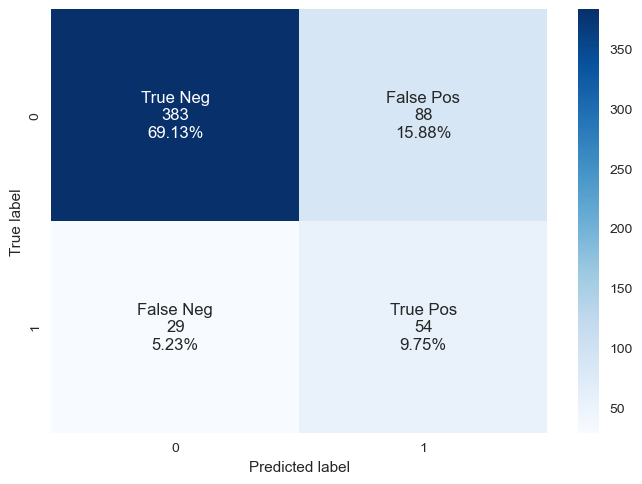

In [79]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

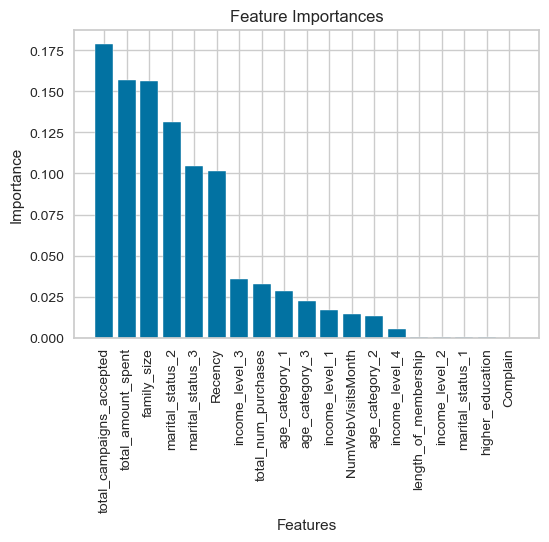

In [80]:
# Call the plot_feature_importances function
plot_feature_importances(rf, X_train2.columns)

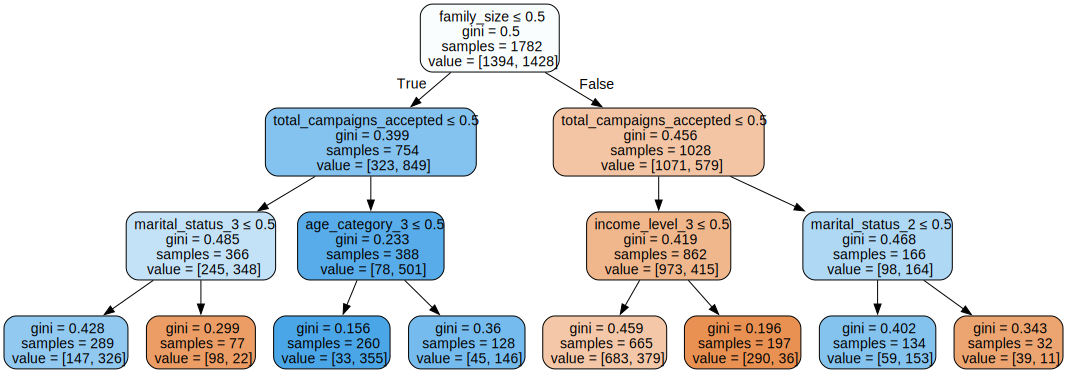

In [81]:
# Accessing one of the decision trees from the random forest
tree_in_forest = rf.estimators_[1]

# Export the decision tree to Graphviz format
dot_data = tree.export_graphviz(tree_in_forest, out_file=None,
                                feature_names=[re.sub('[^a-zA-Z0-9_]', '_', feature) for feature in X_train.columns],
                                filled=True, rounded=True,
                                special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
# graph.render("random_forest_tree")  # Optionally save the tree to a file
# graph.view()  # View the tree in the default viewer
graph

#### Precision-Recall Curve

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


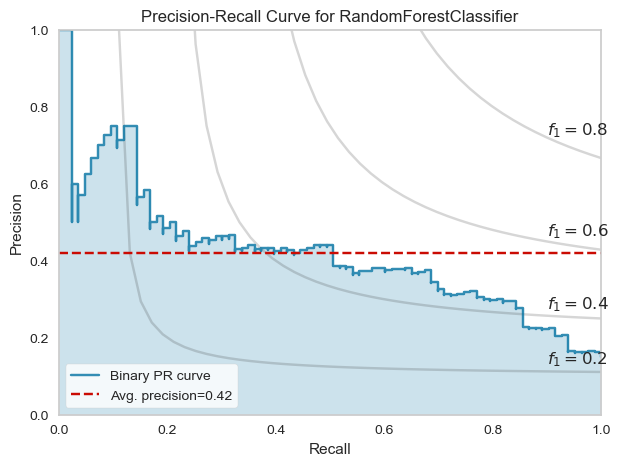

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [82]:
plt.figure(figsize=(7,5))
# Precison-Recall curve
viz = PrecisionRecallCurve(rf, ap_score=True, iso_f1_curves=True)
viz.fit(X_train2, y_train2)
viz.score(X_test, y_test)

viz.show()

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


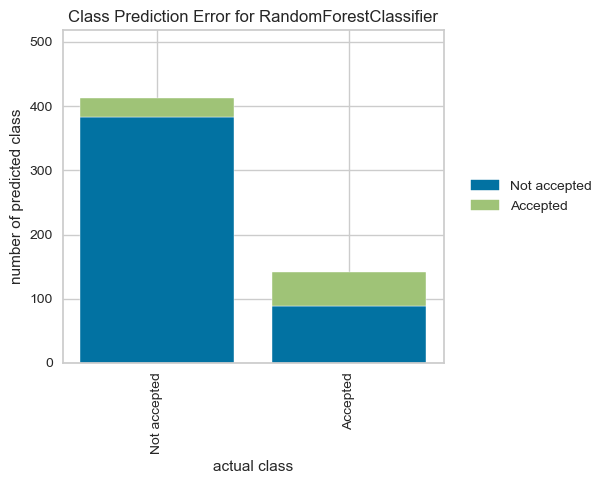

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [83]:
plt.figure(figsize=(7,5))
classes = ['Not accepted','Accepted']
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(rf, classes=classes)

# Fit the training data to the visualizer
visualizer.fit(X_train2, y_train2)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

### XGBoost 

#### GridSearchCV - Hyperparameter Tuning 

In [84]:
# Define the XGBoost classifier
xgb_cf = XGBClassifier()

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [50],
    'max_depth': [3], 
    'learning_rate': [0.01, 0.02], 
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_cf, param_grid=param_grid, cv=10, n_jobs=-1, scoring='f1_weighted')

# Perform Grid Search cross-validation
grid_search.fit(X_train2, y_train2)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best F1 score found
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 50}
Best F1 Score: 0.8333845177233625


In [85]:
# Initiate the XGBoost classifier
xgb_cf = XGBClassifier(**grid_search.best_params_, random_state=random_state)

#### Learning Curve

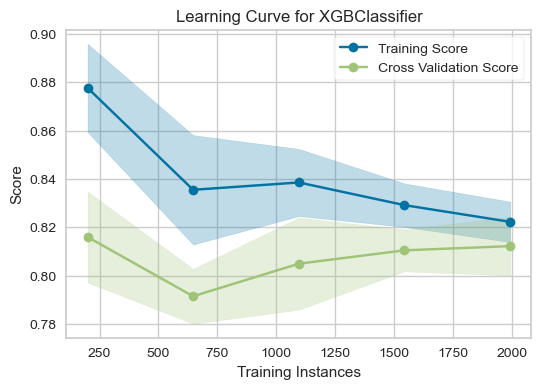

<Axes: title={'center': 'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [86]:
plt.figure(figsize=(6,4))
# Plot the learning curve
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=xgb_cf, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, random_state=random_state)
visualizer.fit(X, y)
visualizer.show()   

#### Cross Validation

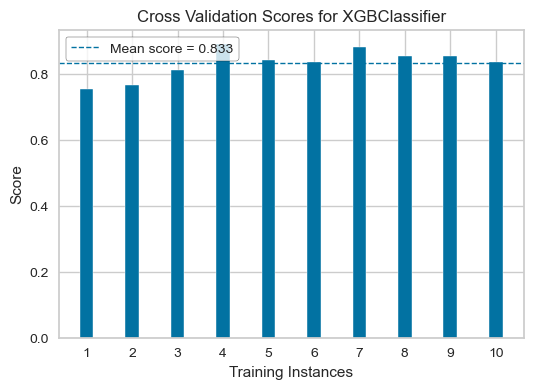

<Axes: title={'center': 'Cross Validation Scores for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [87]:
plt.figure(figsize=(6,4))
# Visualize cross validation scores
visualizer = CVScores(xgb_cf, cv=10, scoring='f1_weighted')

visualizer.fit(X_train2, y_train2)        # Fit the data to the visualizer
visualizer.show()                         # Finalize and render the figure

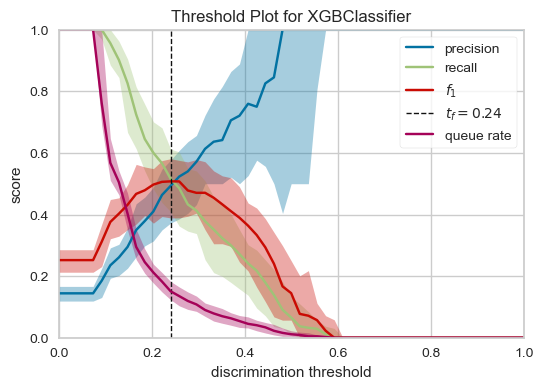

<Axes: title={'center': 'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [88]:
plt.figure(figsize=(6,4))
# Instantiate the DiscriminationThreshold visualizer with the model
visualizer = DiscriminationThreshold(xgb_cf)

# Fit the data to the visualizer
visualizer.fit(X, y)

# Visualize the discrimination threshold
visualizer.show()

In [89]:
# Train the model
xgb_cf.fit(X_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=2024, ...)

In [90]:
# predict y for X_train and X_test
y_pred_train = xgb_cf.predict(X_train2) 
y_pred_test = xgb_cf.predict(X_test) 

In [91]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,Accuracy,0.847271,0.763538
1,Precision,0.848506,0.337838
2,Recall,0.845500,0.602410
3,F1-score,0.847000,0.432900
4,Specificity,0.849043,0.791932
5,G-Mean,0.847270,0.690701


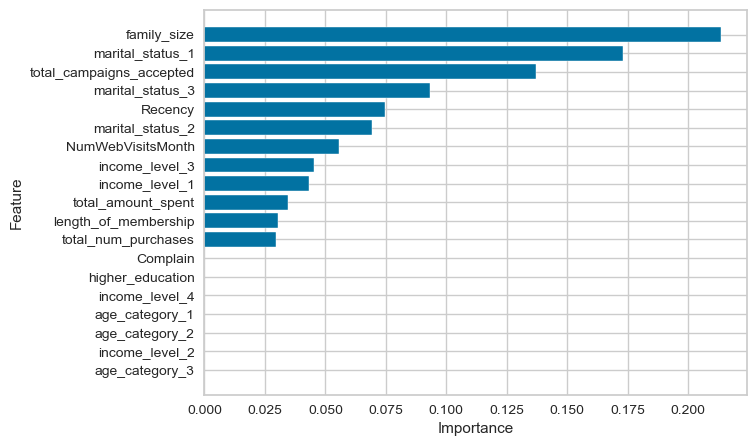

In [92]:
# Get feature importances
feature_importances = xgb_cf.feature_importances_

# Get feature names
feature_names = X_train2.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(7, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

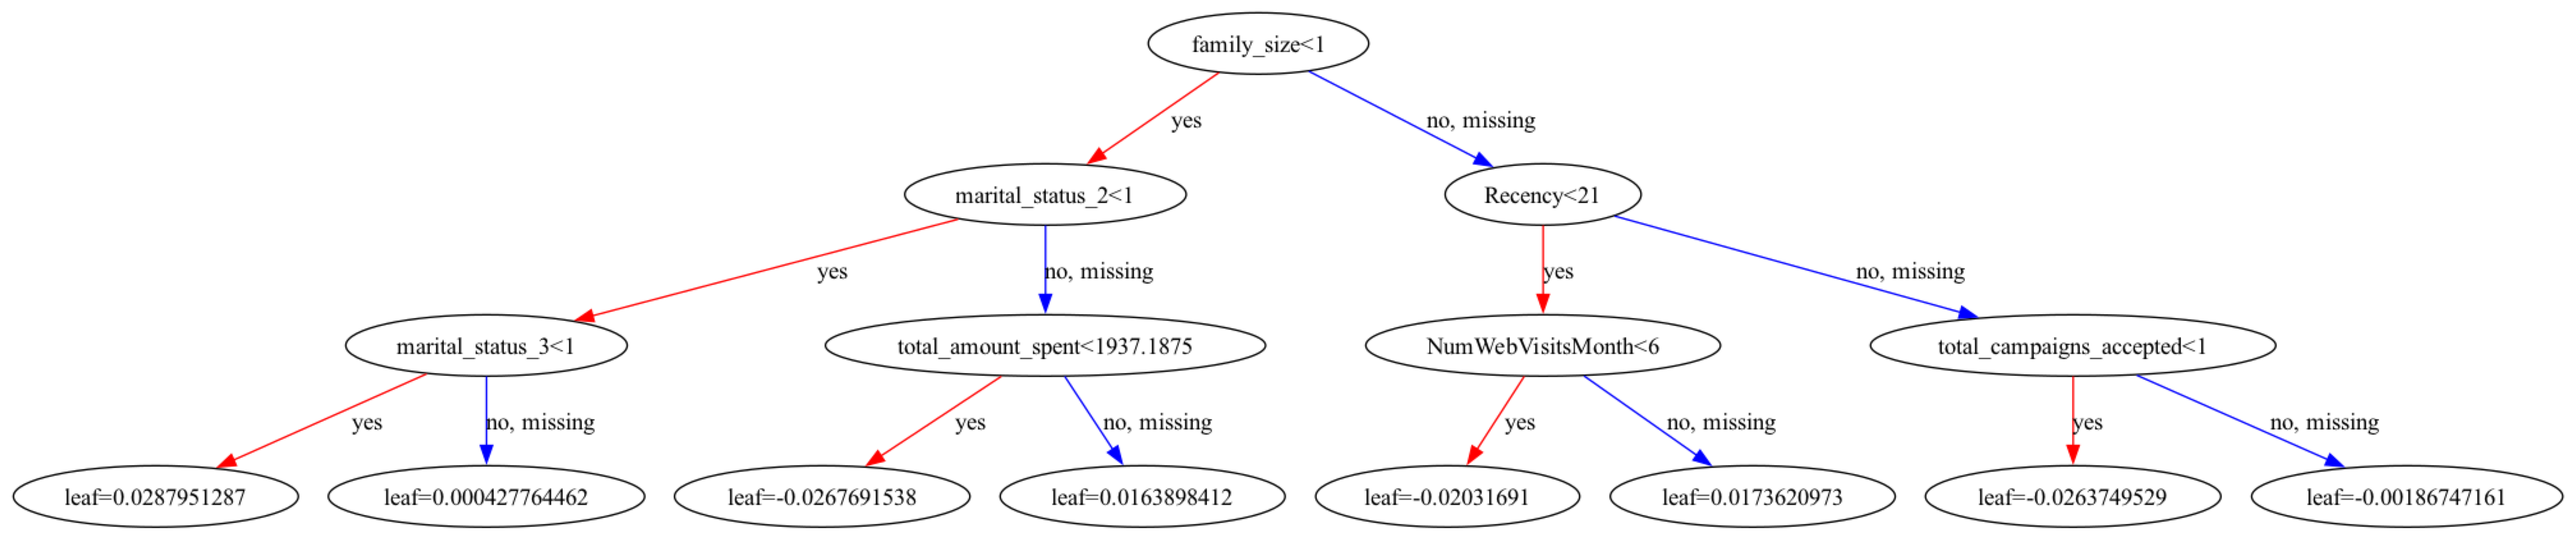

In [93]:
# Visualize the first tree in the booster
xgb.plot_tree(xgb_cf, num_trees=1)
plt.gcf().set_size_inches(50, 50)
plt.show()

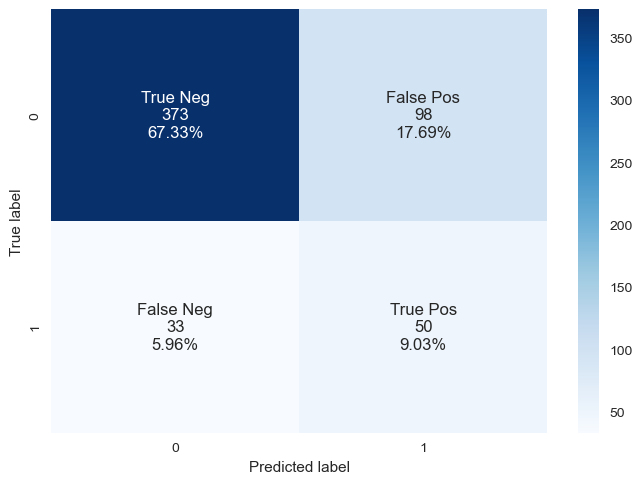

In [94]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

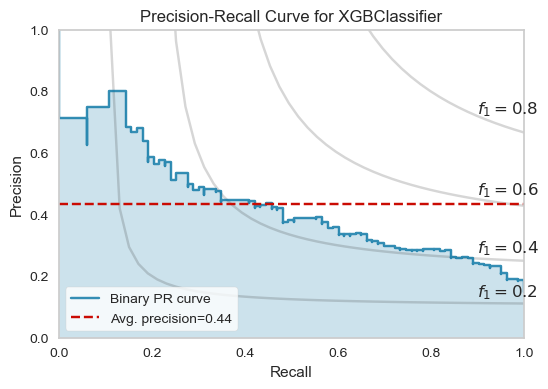

<Axes: title={'center': 'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [95]:
plt.figure(figsize=(6,4))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(xgb_cf, ap_score=True, iso_f1_curves=True,)
viz.fit(X_train2, y_train2)
viz.score(X_test, y_test)

viz.show()

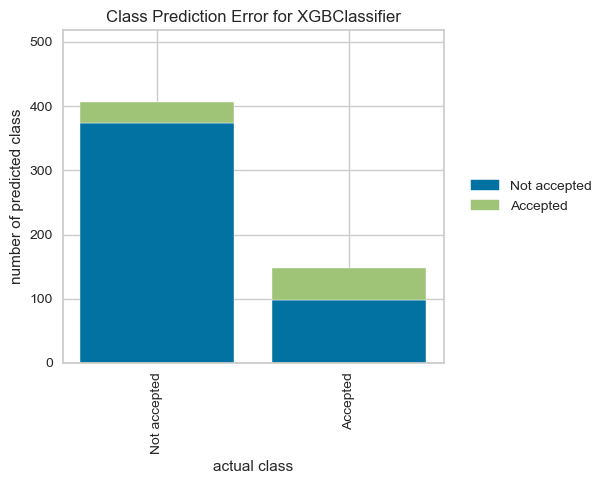

<Axes: title={'center': 'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [96]:
plt.figure(figsize=(7,5))
classes = ['Not accepted','Accepted']
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(xgb_cf, classes=classes)

# Fit the training data to the visualizer
visualizer.fit(X_train2, y_train2)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()